# exp14: Rolling Window Validation

**ベースライン**: exp13の特徴量とモデルを使用

**exp13からの改善点**:
- 検証方法を **Rolling Window Validation** に変更
- 時系列データを複数の期間に分割して評価
- より安定した性能評価が可能

**Rolling Window設定**:
- Window size: 2ヶ月（約40-45営業日）
- Step: 1ヶ月（約20営業日）
- 各Windowで Train → Test の評価を実施
- 最終スコアは全Windowの平均

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# Best Optuna Parameters (from exp05 optimization)
# ============================================================================

BEST_PARAMS = {
    'Ridge': {'alpha': 70.4183028501599},
    'ExtraTrees': {
        'n_estimators': 229,
        'max_depth': 29,
        'min_samples_split': 16,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'HistGradientBoosting': {
        'max_iter': 238,
        'learning_rate': 0.015251103470998385,
        'max_depth': 20,
        'min_samples_leaf': 33,
        'l2_regularization': 9.037967498117355
    },
    'LightGBM': {
        'n_estimators': 127,
        'learning_rate': 0.1601531217136121,
        'num_leaves': 112,
        'max_depth': 12,
        'subsample': 0.9085081386743783,
        'colsample_bytree': 0.6296178606936361,
        'reg_lambda': 0.5211124595788266,
        'reg_alpha': 0.5793452976256486
    },
    'CatBoost': {
        'iterations': 2295,
        'learning_rate': 0.10429705988762059,
        'depth': 5,
        'l2_leaf_reg': 6.359326196557493,
        'subsample': 0.8738193035765242
    }
}

print('Best parameters loaded from exp05 optimization')

Best parameters loaded from exp05 optimization


In [3]:
# ==================================================================================
# Step 1-6: データの読み込みと特徴量作成（exp13と同じ）
# ==================================================================================

def load_and_preprocess_data():
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nデータ期間: {call_data['cdr_date'].min()} ~ {call_data['cdr_date'].max()}")
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [4]:
# ==================================================================================
# データ準備
# ==================================================================================

print("\n" + "*" * 80)
print("exp14: Rolling Window Validation")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")


********************************************************************************
exp14: Rolling Window Validation
********************************************************************************
Step 1: データの読み込み

データ期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00

Step 2: データの統合

平日データ数: 477行
期間: 2018-06-01 00:00:00 ~ 2020-03-30 00:00:00


In [5]:
# ==================================================================================
# Rolling Window Validation の設定
# ==================================================================================

# 特徴量リスト
feature_cols = [
    'dow', 'day_of_month', 'month', 'quarter', 'year', 
    'days_from_start', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    'woy', 'wom', 'day_before_holiday_flag',
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    'ma_3', 'ma_7', 'ma_14', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30'
]

# Rolling Window設定
test_window_days = 60  # テストウィンドウ: 2ヶ月
step_days = 30  # ステップ: 1ヶ月

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()

print("\n" + "=" * 80)
print("Rolling Window Validation 設定")
print("=" * 80)
print(f"テストウィンドウ: {test_window_days}日（約2ヶ月）")
print(f"ステップ: {step_days}日（約1ヶ月）")
print(f"\n使用データ: {len(df_clean)}行")
print(f"期間: {df_clean['cdr_date'].min()} ~ {df_clean['cdr_date'].max()}")

# Rolling Window の分割点を計算
min_date = df_clean['cdr_date'].min()
max_date = df_clean['cdr_date'].max()
total_days = (max_date - min_date).days

# 最低限の訓練データを確保（90日 = 約3ヶ月）
min_train_days = 90

windows = []
current_test_end = max_date

while True:
    test_start = current_test_end - pd.Timedelta(days=test_window_days)
    train_end = test_start - pd.Timedelta(days=1)
    
    # 訓練データが最低限の期間を満たすかチェック
    if (train_end - min_date).days < min_train_days:
        break
    
    windows.append({
        'train_start': min_date,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': current_test_end
    })
    
    # 次のウィンドウへ
    current_test_end = test_start - pd.Timedelta(days=1)

windows = windows[::-1]  # 時系列順に並べ替え

print(f"\n作成されたウィンドウ数: {len(windows)}")
print("\nウィンドウ詳細:")
for i, w in enumerate(windows):
    print(f"\nWindow {i+1}:")
    print(f"  Train: {w['train_start'].strftime('%Y-%m-%d')} ~ {w['train_end'].strftime('%Y-%m-%d')}")
    print(f"  Test : {w['test_start'].strftime('%Y-%m-%d')} ~ {w['test_end'].strftime('%Y-%m-%d')}")


Rolling Window Validation 設定
テストウィンドウ: 60日（約2ヶ月）
ステップ: 30日（約1ヶ月）

使用データ: 456行
期間: 2018-07-02 00:00:00 ~ 2020-03-30 00:00:00

作成されたウィンドウ数: 8

ウィンドウ詳細:

Window 1:
  Train: 2018-07-02 ~ 2018-11-28
  Test : 2018-11-29 ~ 2019-01-28

Window 2:
  Train: 2018-07-02 ~ 2019-01-28
  Test : 2019-01-29 ~ 2019-03-30

Window 3:
  Train: 2018-07-02 ~ 2019-03-30
  Test : 2019-03-31 ~ 2019-05-30

Window 4:
  Train: 2018-07-02 ~ 2019-05-30
  Test : 2019-05-31 ~ 2019-07-30

Window 5:
  Train: 2018-07-02 ~ 2019-07-30
  Test : 2019-07-31 ~ 2019-09-29

Window 6:
  Train: 2018-07-02 ~ 2019-09-29
  Test : 2019-09-30 ~ 2019-11-29

Window 7:
  Train: 2018-07-02 ~ 2019-11-29
  Test : 2019-11-30 ~ 2020-01-29

Window 8:
  Train: 2018-07-02 ~ 2020-01-29
  Test : 2020-01-30 ~ 2020-03-30


---

# モデル学習と評価

In [6]:
# ============================================================================
# 評価関数
# ============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


In [7]:
# ============================================================================
# Rolling Window Validation の実行
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.optimize import minimize

# 各モデルの全ウィンドウでの結果を保存
all_window_results = []

print("\n" + "=" * 80)
print("Rolling Window Validation 実行")
print("=" * 80)

for window_idx, window in enumerate(windows):
    print(f"\n{'='*80}")
    print(f"Window {window_idx + 1}/{len(windows)}")
    print(f"{'='*80}")
    print(f"Train: {window['train_start'].strftime('%Y-%m-%d')} ~ {window['train_end'].strftime('%Y-%m-%d')}")
    print(f"Test : {window['test_start'].strftime('%Y-%m-%d')} ~ {window['test_end'].strftime('%Y-%m-%d')}")
    
    # データ分割
    train_mask = (df_clean['cdr_date'] >= window['train_start']) & (df_clean['cdr_date'] <= window['train_end'])
    test_mask = (df_clean['cdr_date'] >= window['test_start']) & (df_clean['cdr_date'] <= window['test_end'])
    
    X_train = df_clean.loc[train_mask, feature_cols]
    y_train = df_clean.loc[train_mask, 'target_next_day']
    X_test = df_clean.loc[test_mask, feature_cols]
    y_test = df_clean.loc[test_mask, 'target_next_day']
    
    print(f"\nTrain: {len(X_train)}件, Test: {len(X_test)}件")
    
    # 各モデルの訓練と評価
    window_models = {}
    window_predictions = {}
    
    # 1. HistGradientBoosting
    print("\n[1/5] HistGradientBoosting...")
    hist_model = HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
    hist_model.fit(X_train, y_train)
    hist_pred = hist_model.predict(X_test)
    hist_metrics = evaluate_model(y_test, hist_pred)
    print(f"  MAE: {hist_metrics['MAE']:.2f}, RMSE: {hist_metrics['RMSE']:.2f}, R2: {hist_metrics['R2']:.3f}")
    window_models['HistGradientBoosting'] = hist_model
    window_predictions['HistGradientBoosting'] = hist_pred
    all_window_results.append({'window': window_idx+1, 'model': 'HistGradientBoosting', **hist_metrics})
    
    # 2. ExtraTrees
    print("[2/5] ExtraTrees...")
    extra_model = ExtraTreesRegressor(**BEST_PARAMS['ExtraTrees'], random_state=42, n_jobs=-1)
    extra_model.fit(X_train, y_train)
    extra_pred = extra_model.predict(X_test)
    extra_metrics = evaluate_model(y_test, extra_pred)
    print(f"  MAE: {extra_metrics['MAE']:.2f}, RMSE: {extra_metrics['RMSE']:.2f}, R2: {extra_metrics['R2']:.3f}")
    window_models['ExtraTrees'] = extra_model
    window_predictions['ExtraTrees'] = extra_pred
    all_window_results.append({'window': window_idx+1, 'model': 'ExtraTrees', **extra_metrics})
    
    # 3. CatBoost
    print("[3/5] CatBoost...")
    catboost_model = CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0)
    catboost_model.fit(X_train, y_train)
    catboost_pred = catboost_model.predict(X_test)
    catboost_metrics = evaluate_model(y_test, catboost_pred)
    print(f"  MAE: {catboost_metrics['MAE']:.2f}, RMSE: {catboost_metrics['RMSE']:.2f}, R2: {catboost_metrics['R2']:.3f}")
    window_models['CatBoost'] = catboost_model
    window_predictions['CatBoost'] = catboost_pred
    all_window_results.append({'window': window_idx+1, 'model': 'CatBoost', **catboost_metrics})
    
    # 4. Ridge
    print("[4/5] Ridge...")
    ridge_model = Ridge(**BEST_PARAMS['Ridge'], random_state=42)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    ridge_metrics = evaluate_model(y_test, ridge_pred)
    print(f"  MAE: {ridge_metrics['MAE']:.2f}, RMSE: {ridge_metrics['RMSE']:.2f}, R2: {ridge_metrics['R2']:.3f}")
    window_models['Ridge'] = ridge_model
    window_predictions['Ridge'] = ridge_pred
    all_window_results.append({'window': window_idx+1, 'model': 'Ridge', **ridge_metrics})
    
    # 5. Weighted Ensemble A: Ridge + CatBoost + ExtraTrees + HistGB
    print("[5/5] WeightedEnsemble_A...")
    
    # 重み最適化
    def optimize_weights(predictions_dict, y_true, model_names):
        preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
        
        def objective(weights):
            ensemble_pred = preds_matrix @ weights
            return mean_absolute_error(y_true, ensemble_pred)
        
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
        bounds = [(0, 1) for _ in range(len(model_names))]
        initial_weights = np.ones(len(model_names)) / len(model_names)
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x
    
    pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
    weights_a = optimize_weights(window_predictions, y_test, pattern_a_models)
    
    weightA_pred = np.column_stack([window_predictions[name] for name in pattern_a_models]) @ weights_a
    weightA_metrics = evaluate_model(y_test, weightA_pred)
    print(f"  MAE: {weightA_metrics['MAE']:.2f}, RMSE: {weightA_metrics['RMSE']:.2f}, R2: {weightA_metrics['R2']:.3f}")
    all_window_results.append({'window': window_idx+1, 'model': 'WeightedEnsemble_A', **weightA_metrics})

print("\n" + "=" * 80)
print("Rolling Window Validation 完了")
print("=" * 80)


Rolling Window Validation 実行

Window 1/8
Train: 2018-07-02 ~ 2018-11-28
Test : 2018-11-29 ~ 2019-01-28

Train: 108件, Test: 43件

[1/5] HistGradientBoosting...
  MAE: 58.20, RMSE: 66.95, R2: 0.009
[2/5] ExtraTrees...
  MAE: 50.74, RMSE: 73.67, R2: -0.200
[3/5] CatBoost...
  MAE: 48.46, RMSE: 62.26, R2: 0.143
[4/5] Ridge...
  MAE: 125.45, RMSE: 148.11, R2: -3.851
[5/5] WeightedEnsemble_A...
  MAE: 33.22, RMSE: 42.94, R2: 0.592

Window 2/8
Train: 2018-07-02 ~ 2019-01-28
Test : 2019-01-29 ~ 2019-03-30

Train: 151件, Test: 44件

[1/5] HistGradientBoosting...
  MAE: 42.34, RMSE: 54.91, R2: 0.142
[2/5] ExtraTrees...
  MAE: 78.79, RMSE: 94.04, R2: -1.516
[3/5] CatBoost...
  MAE: 47.19, RMSE: 59.14, R2: 0.005
[4/5] Ridge...
  MAE: 69.99, RMSE: 85.53, R2: -1.081
[5/5] WeightedEnsemble_A...
  MAE: 40.72, RMSE: 53.38, R2: 0.189

Window 3/8
Train: 2018-07-02 ~ 2019-03-30
Test : 2019-03-31 ~ 2019-05-30

Train: 195件, Test: 44件

[1/5] HistGradientBoosting...
  MAE: 23.41, RMSE: 32.32, R2: 0.769
[2/5] Ex

---

# 結果の集計と可視化

In [8]:
# ============================================================================
# 結果の集計
# ============================================================================

results_df = pd.DataFrame(all_window_results)

print("\n" + "=" * 80)
print("全ウィンドウの結果")
print("=" * 80)
print(results_df.to_string(index=False))

# モデルごとの平均スコア
print("\n" + "=" * 80)
print("モデルごとの平均スコア（全ウィンドウ）")
print("=" * 80)

average_scores = results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].mean()
average_scores = average_scores.sort_values('MAE')
print(average_scores.to_string())

# 標準偏差も確認（スコアの安定性）
print("\n" + "=" * 80)
print("モデルごとの標準偏差（スコアの安定性）")
print("=" * 80)

std_scores = results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].std()
std_scores = std_scores.sort_values('MAE')
print(std_scores.to_string())

# CSV保存
import os
output_dir = '../output/exp14'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

results_df.to_csv(f'{output_dir}/rolling_window_results.csv', index=False)
average_scores.to_csv(f'{output_dir}/average_scores.csv')
std_scores.to_csv(f'{output_dir}/std_scores.csv')

print(f"\n結果を保存しました: {output_dir}/")


全ウィンドウの結果
 window                model        MAE       RMSE        R2       WAPE
      1 HistGradientBoosting  58.196439  66.948903  0.008752  98.832815
      1           ExtraTrees  50.739905  73.670942 -0.200294  86.169666
      1             CatBoost  48.461364  62.264554  0.142613  82.300105
      1                Ridge 125.450401 148.109331 -3.851323 213.047679
      1   WeightedEnsemble_A  33.219370  42.937303  0.592277  56.415201
      2 HistGradientBoosting  42.337518  54.909275  0.142242  45.468654
      2           ExtraTrees  78.792518  94.039417 -1.515900  84.619741
      2             CatBoost  47.192037  59.144508  0.004818  50.682198
      2                Ridge  69.992608  85.532632 -1.081312  75.169021
      2   WeightedEnsemble_A  40.719925  53.377452  0.189433  43.731431
      3 HistGradientBoosting  23.408503  32.322372  0.768817  19.999498
      3           ExtraTrees  23.531973  33.217429  0.755836  20.104987
      3             CatBoost  25.042598  32.836803  0

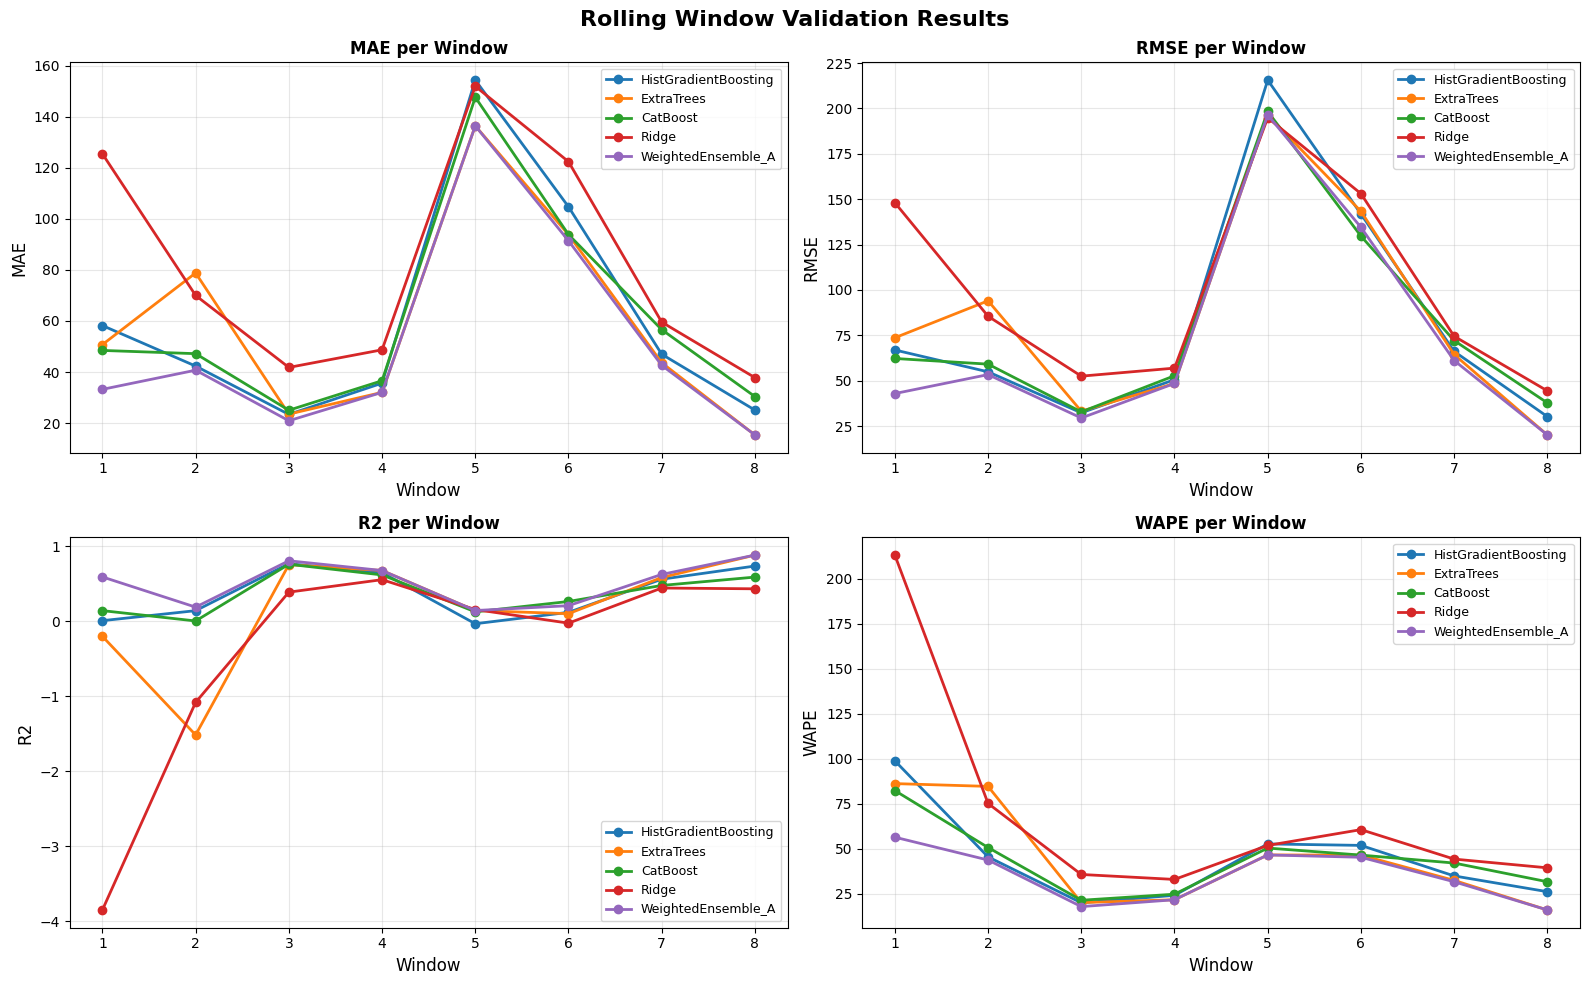


可視化を保存しました: ../output/exp14/rolling_window_trends.png


In [9]:
# ============================================================================
# 可視化: ウィンドウごとのMAE推移
# ============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Rolling Window Validation Results', fontsize=16, fontweight='bold')

metrics_to_plot = ['MAE', 'RMSE', 'R2', 'WAPE']
models = results_df['model'].unique()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    for model in models:
        model_data = results_df[results_df['model'] == model]
        ax.plot(model_data['window'], model_data[metric], marker='o', label=model, linewidth=2)
    
    ax.set_xlabel('Window', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} per Window', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xticks(range(1, len(windows) + 1))

plt.tight_layout()
plt.savefig(f'{output_dir}/rolling_window_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n可視化を保存しました: {output_dir}/rolling_window_trends.png")

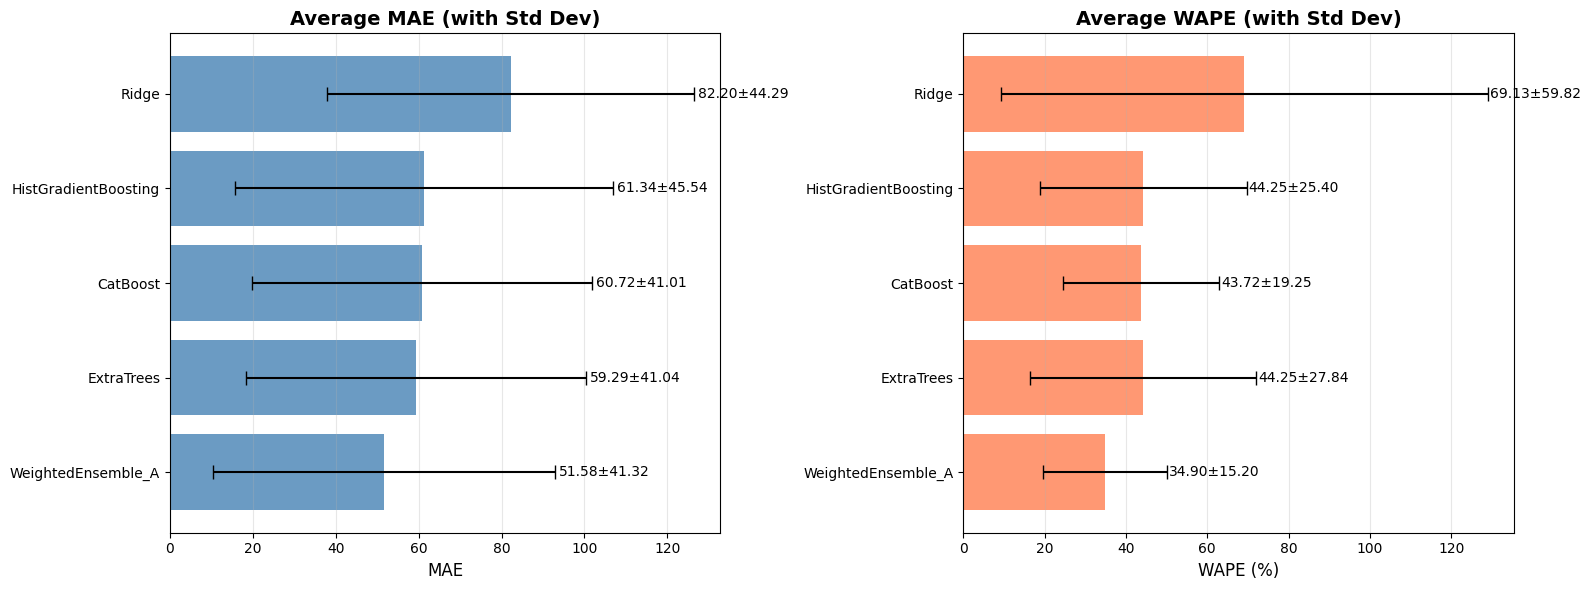


可視化を保存しました: ../output/exp14/average_scores_comparison.png


In [10]:
# ============================================================================
# 可視化: 平均スコアと標準偏差
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 平均MAE
ax = axes[0]
models_sorted = average_scores.index
mae_means = average_scores['MAE']
mae_stds = std_scores.loc[models_sorted, 'MAE']

bars = ax.barh(range(len(models_sorted)), mae_means, xerr=mae_stds, 
               color='steelblue', alpha=0.8, capsize=5)
ax.set_yticks(range(len(models_sorted)))
ax.set_yticklabels(models_sorted)
ax.set_xlabel('MAE', fontsize=12)
ax.set_title('Average MAE (with Std Dev)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (mean, std) in enumerate(zip(mae_means, mae_stds)):
    ax.text(mean + std + 1, i, f'{mean:.2f}±{std:.2f}', 
            va='center', fontsize=10)

# WAPE
ax = axes[1]
wape_means = average_scores['WAPE']
wape_stds = std_scores.loc[models_sorted, 'WAPE']

bars = ax.barh(range(len(models_sorted)), wape_means, xerr=wape_stds, 
               color='coral', alpha=0.8, capsize=5)
ax.set_yticks(range(len(models_sorted)))
ax.set_yticklabels(models_sorted)
ax.set_xlabel('WAPE (%)', fontsize=12)
ax.set_title('Average WAPE (with Std Dev)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for i, (mean, std) in enumerate(zip(wape_means, wape_stds)):
    ax.text(mean + std + 0.5, i, f'{mean:.2f}±{std:.2f}', 
            va='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{output_dir}/average_scores_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n可視化を保存しました: {output_dir}/average_scores_comparison.png")

---

## Summary

**exp14: Rolling Window Validation**

### 検証方法:
- **Rolling Window Validation** を使用
- テストウィンドウ: 2ヶ月（約60日）
- ステップ: 1ヶ月（約30日）
- 最低訓練期間: 3ヶ月（約90日）

### 評価したモデル:
1. **HistGradientBoosting**
2. **ExtraTrees**
3. **CatBoost**
4. **Ridge**
5. **WeightedEnsemble_A**: Ridge + CatBoost + ExtraTrees + HistGB

### 評価指標:
- **平均スコア**: 全ウィンドウの平均値
- **標準偏差**: スコアの安定性（小さいほど安定）

### exp13との比較:
- **exp13**: 単一のValidation/Test分割
- **exp14**: 複数のウィンドウで評価（より頑健な評価）

### 出力ファイル:
1. `rolling_window_results.csv` - 全ウィンドウの詳細結果
2. `average_scores.csv` - モデルごとの平均スコア
3. `std_scores.csv` - モデルごとの標準偏差
4. `rolling_window_trends.png` - ウィンドウごとの推移
5. `average_scores_comparison.png` - 平均スコアの比較